### Real-Time Parallel Shoplifting Detection using Multimodal AI

#### Parallel Data Loading

Starting data loading comparison with data from: /home/patel.vanshi/PRO_DATASET
Directory structure:
  - HPC_PRO_DATA: /home/patel.vanshi/PRO_DATASET/HPC_PRO_DATA
  - Found folder: HPC_PRO_DATA/Anomaly-Videos-Part-1/Arrest
    - Contains 50 video files
  - Found folder: HPC_PRO_DATA/Anomaly-Videos-Part-2/Burglary
    - Contains 100 video files
  - Found folder: HPC_PRO_DATA/Anomaly-Videos-Part-3/Robbery
    - Contains 150 video files
  - Found folder: HPC_PRO_DATA/Anomaly-Videos-Part-4/Shoplifting
    - Contains 50 video files
  - Found folder: HPC_PRO_DATA/Anomaly-Videos-Part-4/Stealing
    - Contains 100 video files
  - Found folder: HPC_PRO_DATA/Normal_Videos_for_Event_Recognition
    - Contains 50 video files
  - Found folder: HPC_PRO_DATA/Testing_Normal_Videos_Anomaly
    - Contains 150 video files
  - Found folder: HPC_PRO_DATA/Training-Normal-Videos-Part-1
    - Contains 130 video files
  - Found folder: HPC_PRO_DATA/Training-Normal-Videos-Part-2
    - Contains 137 video files



100%|██████████| 917/917 [10:05<00:00,  1.51it/s]


Processing JSON files with Joblib (1 CPUs, 4 workers per CPU)...


100%|██████████| 151/151 [00:02<00:00, 60.00it/s]


Processing pickle files with Joblib (1 CPUs, 4 workers per CPU)...


0it [00:00, ?it/s]


Joblib total elapsed time: 607.89 seconds

Running Dask data loading with 1 CPUs...
Dask dashboard available at: http://127.0.0.1:8787/status
Found 917 videos, 151 JSON files, 0 pickle files
Processing videos with Dask (1 CPUs, 4 workers per CPU)...
Processing JSON files with Dask (1 CPUs, 4 workers per CPU)...
Processing pickle files with Dask (1 CPUs, 4 workers per CPU)...
Dask total elapsed time: 331.27 seconds

With 1 CPUs:
  Joblib time: 607.89 seconds
  Dask time: 331.27 seconds
  Faster approach: Dask
  Time difference: 276.62 seconds (83.50% faster)


Testing with 2 CPUs (4 workers per CPU)

Running Joblib data loading with 2 CPUs...
Found 917 videos, 151 JSON files, 0 pickle files
Processing videos with Joblib (2 CPUs, 4 workers per CPU)...


100%|██████████| 917/917 [07:46<00:00,  1.96it/s]


Processing JSON files with Joblib (2 CPUs, 4 workers per CPU)...


100%|██████████| 151/151 [00:01<00:00, 149.05it/s]


Processing pickle files with Joblib (2 CPUs, 4 workers per CPU)...


0it [00:00, ?it/s]

Joblib total elapsed time: 469.57 seconds

Running Dask data loading with 2 CPUs...


Dask dashboard available at: http://127.0.0.1:8787/status
Found 917 videos, 151 JSON files, 0 pickle files
Processing videos with Dask (2 CPUs, 4 workers per CPU)...
Processing JSON files with Dask (2 CPUs, 4 workers per CPU)...
Processing pickle files with Dask (2 CPUs, 4 workers per CPU)...
Dask total elapsed time: 263.60 seconds

With 2 CPUs:
  Joblib time: 469.57 seconds
  Dask time: 263.60 seconds
  Faster approach: Dask
  Time difference: 205.98 seconds (78.14% faster)

Performance Summary:
   CPU Count  Joblib Time (s)  Dask Time (s) Faster Approach  \
0          1       607.894091     331.272425            Dask   
1          2       469.571962     263.596920            Dask   

  Speed Difference (%)  
0               83.50%  
1               78.14%  

Loading data for statistics with 4 CPUs...
Found 917 videos, 151 JSON files, 0 pickle files
Processing videos with Joblib (4 CPUs, 4 workers per CPU)...


100%|██████████| 917/917 [04:08<00:00,  3.69it/s]


Processing JSON files with Joblib (4 CPUs, 4 workers per CPU)...


100%|██████████| 151/151 [00:00<00:00, 330.50it/s]


Processing pickle files with Joblib (4 CPUs, 4 workers per CPU)...


0it [00:00, ?it/s]

Joblib total elapsed time: 251.24 seconds



Data Statistics:
               Metric       Value
0        Total Videos  917.000000
1      Average Frames  157.408942
2    Total JSON Files  151.000000
3  Total Pickle Files    0.000000

Label Distribution:
         Label  Count
0       Normal    467
1      Robbery    150
2     Stealing    100
3     Burglary    100
4       Arrest     50
5  Shoplifting     50

Comparison complete. Results saved to parallel_benchmark_results directory.


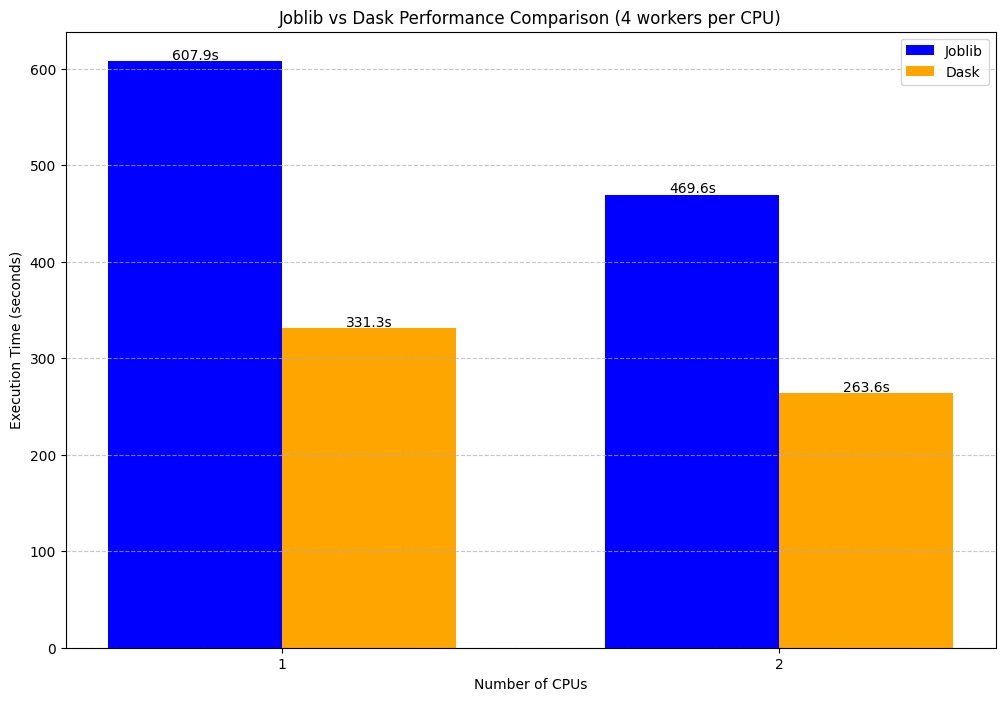

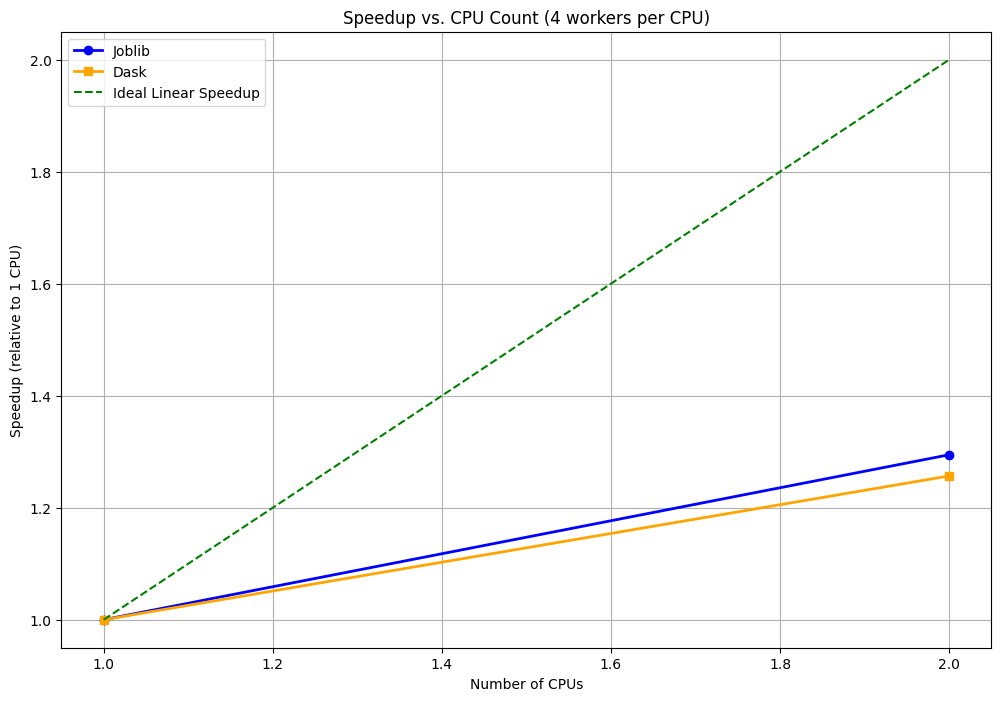

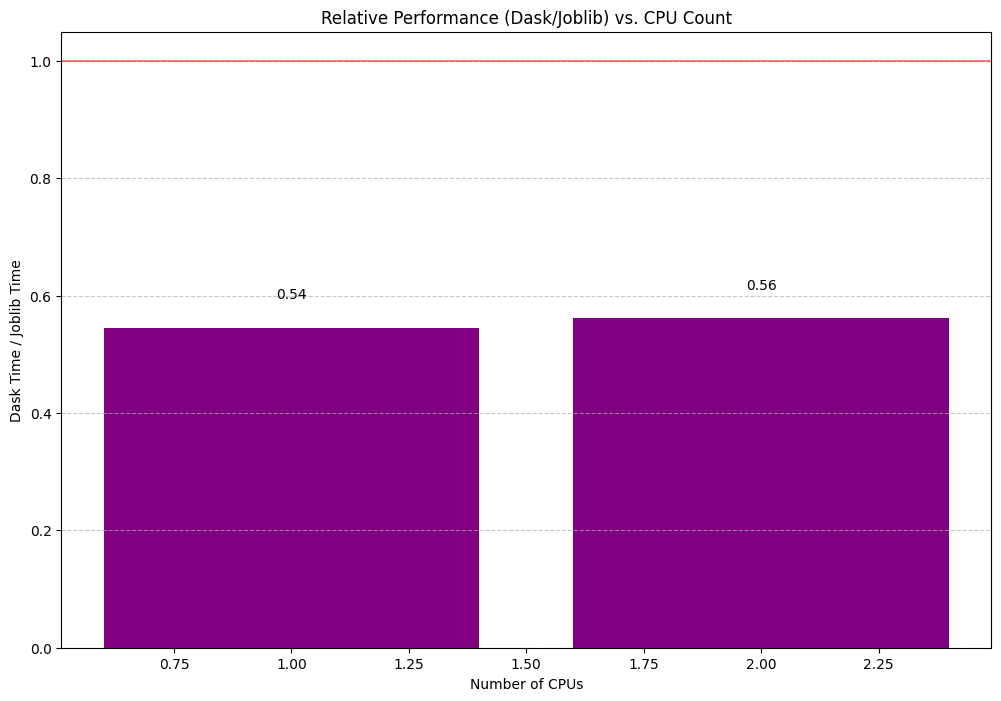

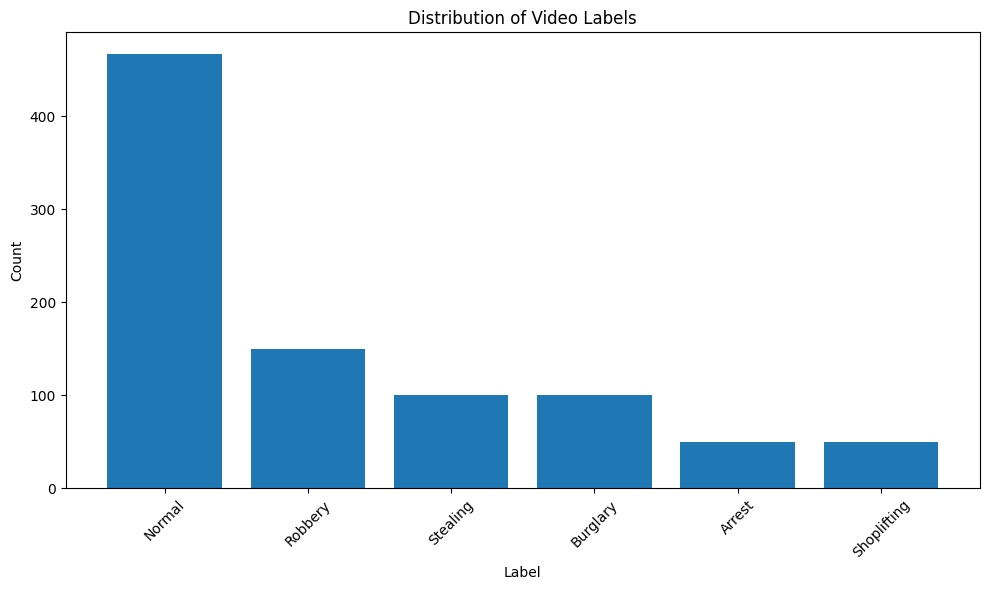

In [ ]:
import os
import cv2
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import warnings
warnings.filterwarnings('ignore')

# Define paths
DATA_ROOT = "/home/patel.vanshi/PRO_DATASET"  # Root directory path
HPC_PRO_DATA = "/home/patel.vanshi/PRO_DATASET/HPC_PRO_DATA"  # HPC_PRO_DATA path

UCF_CRIME_FOLDERS = [
    "HPC_PRO_DATA/Anomaly-Videos-Part-1/Arrest",
    "HPC_PRO_DATA/Anomaly-Videos-Part-2/Burglary",
    "HPC_PRO_DATA/Anomaly-Videos-Part-3/Robbery",
    "HPC_PRO_DATA/Anomaly-Videos-Part-4/Shoplifting",
    "HPC_PRO_DATA/Anomaly-Videos-Part-4/Stealing",
    "HPC_PRO_DATA/Normal_Videos_for_Event_Recognition",
    "HPC_PRO_DATA/Testing_Normal_Videos_Anomaly",
    "HPC_PRO_DATA/Training-Normal-Videos-Part-1",
    "HPC_PRO_DATA/Training-Normal-Videos-Part-2"
]

# PoseLift directories
POSELIFT_JSON_DIR = "HPC_PRO_DATA/PoseLift/pose"
POSELIFT_PICKLE_DIR = "HPC_PRO_DATA/PoseLift/Pickle_Files"

# Helper functions
def get_video_paths(root_dir, folders):
    """Get all video paths from specified folders"""
    video_paths = []
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if os.path.exists(folder_path):
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(('.mp4', '.avi')):
                        video_paths.append(os.path.join(root, file))
    return video_paths

def get_json_paths(json_dir):
    """Get all JSON file paths"""
    json_paths = []
    
    # Check if the directory exists
    if not os.path.exists(json_dir):
        print(f"Warning: JSON directory {json_dir} does not exist")
        return json_paths
    
    # Check if directory has train/test subdirectories
    train_test_structure = False
    for split in ['train', 'test']:
        if os.path.exists(os.path.join(json_dir, split)):
            train_test_structure = True
    
    if train_test_structure:
        # If train/test structure exists
        for split in ['train', 'test']:
            split_dir = os.path.join(json_dir, split)
            if os.path.exists(split_dir):
                json_paths.extend([
                    os.path.join(split_dir, file)
                    for file in os.listdir(split_dir)
                    if file.endswith('.json')
                ])
    else:
        # If no train/test structure, search directly in the directory
        json_paths.extend([
            os.path.join(json_dir, file)
            for file in os.listdir(json_dir)
            if file.endswith('.json')
        ])
    
    return json_paths

def get_pickle_paths(pickle_dir):
    """Get all pickle file paths"""
    pickle_paths = []
    
    # Check if the directory exists
    if not os.path.exists(pickle_dir):
        # Try to find a pickle directory in HPC_PRO_DATA/PoseLift
        alternative_dir = os.path.join(HPC_PRO_DATA, "PoseLift")
        found = False
        
        if os.path.exists(alternative_dir):
            # Search for any directory containing pickle files
            for root, dirs, files in os.walk(alternative_dir):
                pkl_files = [f for f in files if f.endswith('.pkl')]
                if pkl_files:
                    print(f"Found pickle files in {root}")
                    pickle_paths.extend([os.path.join(root, f) for f in pkl_files])
                    found = True
        
        if not found:
            print(f"Warning: Pickle directory {pickle_dir} does not exist and no alternative was found")
        
        return pickle_paths
    
    # If the directory exists, find all .pkl files
    for root, _, files in os.walk(pickle_dir):
        pickle_paths.extend([
            os.path.join(root, file)
            for file in files
            if file.endswith('.pkl')
        ])
    
    return pickle_paths

# Video processing functions
def extract_frames(video_path, sample_rate=30):
    """Extract frames from a video file at the given sample rate"""
    try:
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count % sample_rate == 0:
                # Resize frame to a standard size
                frame = cv2.resize(frame, (224, 224))
                frames.append(frame)
            
            frame_count += 1
        
        cap.release()
        return np.array(frames) if frames else None
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return None

def load_json_file(json_path):
    """Load a JSON file"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON {json_path}: {e}")
        return None

def load_pickle_file(pickle_path):
    """Load a pickle file"""
    try:
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading pickle {pickle_path}: {e}")
        return None

# Get label from path
def get_label_from_path(video_path):
    """Extract label from the video path"""
    path_parts = Path(video_path).parts
    
    # Check for anomaly labels
    for category in ['Arrest', 'Burglary', 'Robbery', 'Shoplifting', 'Stealing']:
        if category in path_parts:
            return category
    
    # If not an anomaly, it's a normal video
    return "Normal"

# Joblib implementation
def process_video_joblib(video_path, sample_rate=30):
    """Process a single video with Joblib"""
    frames = extract_frames(video_path, sample_rate)
    label = get_label_from_path(video_path)
    return {
        'path': video_path,
        'label': label,
        'frame_count': len(frames) if frames is not None else 0,
        'shape': frames.shape if frames is not None else None
    }

def process_json_joblib(json_path):
    """Process a single JSON file with Joblib"""
    data = load_json_file(json_path)
    return {
        'path': json_path,
        'data_size': len(str(data)) if data is not None else 0
    }

def process_pickle_joblib(pickle_path):
    """Process a single pickle file with Joblib"""
    data = load_pickle_file(pickle_path)
    return {
        'path': pickle_path,
        'data_size': len(pickle.dumps(data)) if data is not None else 0
    }

def load_data_joblib(n_jobs=4):
    """Load all data using Joblib parallelization with specified number of workers"""
    start_time = time.time()
    
    # Get all file paths
    video_paths = get_video_paths(DATA_ROOT, UCF_CRIME_FOLDERS)
    json_paths = get_json_paths(os.path.join(DATA_ROOT, POSELIFT_JSON_DIR))
    pickle_paths = get_pickle_paths(os.path.join(DATA_ROOT, POSELIFT_PICKLE_DIR))
    
    print(f"Found {len(video_paths)} videos, {len(json_paths)} JSON files, {len(pickle_paths)} pickle files")
    
    # Process videos
    print(f"Processing videos with Joblib ({n_jobs} CPUs, 4 workers per CPU)...")
    video_results = Parallel(n_jobs=n_jobs)(
        delayed(process_video_joblib)(path) for path in tqdm(video_paths)
    )
    
    # Process JSON files
    print(f"Processing JSON files with Joblib ({n_jobs} CPUs, 4 workers per CPU)...")
    json_results = Parallel(n_jobs=n_jobs)(
        delayed(process_json_joblib)(path) for path in tqdm(json_paths)
    )
    
    # Process pickle files
    print(f"Processing pickle files with Joblib ({n_jobs} CPUs, 4 workers per CPU)...")
    pickle_results = Parallel(n_jobs=n_jobs)(
        delayed(process_pickle_joblib)(path) for path in tqdm(pickle_paths)
    )
    
    elapsed_time = time.time() - start_time
    
    # Create summary
    video_df = pd.DataFrame(video_results)
    json_df = pd.DataFrame(json_results)
    pickle_df = pd.DataFrame(pickle_results)
    
    print(f"Joblib total elapsed time: {elapsed_time:.2f} seconds")
    
    return {
        'video_df': video_df,
        'json_df': json_df,
        'pickle_df': pickle_df,
        'elapsed_time': elapsed_time,
        'n_jobs': n_jobs,
        'workers_per_cpu': 4
    }

# Dask implementation
def process_video_dask(video_path, sample_rate=30):
    """Process a single video with Dask"""
    frames = extract_frames(video_path, sample_rate)
    label = get_label_from_path(video_path)
    return {
        'path': video_path,
        'label': label,
        'frame_count': len(frames) if frames is not None else 0,
        'shape': str(frames.shape) if frames is not None else None  # Convert to string for serialization
    }

def process_json_dask(json_path):
    """Process a single JSON file with Dask"""
    data = load_json_file(json_path)
    return {
        'path': json_path,
        'data_size': len(str(data)) if data is not None else 0
    }

def process_pickle_dask(pickle_path):
    """Process a single pickle file with Dask"""
    data = load_pickle_file(pickle_path)
    return {
        'path': pickle_path,
        'data_size': len(pickle.dumps(data)) if data is not None else 0
    }

def load_data_dask(n_workers=4):
    """Load all data using Dask parallelization with specified number of workers"""
    start_time = time.time()
    
    # Set up Dask client with 1 workers per CPU
    threads_per_worker = 1  # 1 workers per CPU
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=threads_per_worker)
    client = Client(cluster)
    print(f"Dask dashboard available at: {client.dashboard_link}")
    
    # Get all file paths
    video_paths = get_video_paths(DATA_ROOT, UCF_CRIME_FOLDERS)
    json_paths = get_json_paths(os.path.join(DATA_ROOT, POSELIFT_JSON_DIR))
    pickle_paths = get_pickle_paths(os.path.join(DATA_ROOT, POSELIFT_PICKLE_DIR))
    
    print(f"Found {len(video_paths)} videos, {len(json_paths)} JSON files, {len(pickle_paths)} pickle files")
    
    # Create Dask tasks
    print(f"Processing videos with Dask ({n_workers} CPUs, 4 workers per CPU)...")
    video_tasks = [dask.delayed(process_video_dask)(path) for path in video_paths]
    
    print(f"Processing JSON files with Dask ({n_workers} CPUs, 4 workers per CPU)...")
    json_tasks = [dask.delayed(process_json_dask)(path) for path in json_paths]
    
    print(f"Processing pickle files with Dask ({n_workers} CPUs, 4 workers per CPU)...")
    pickle_tasks = [dask.delayed(process_pickle_dask)(path) for path in pickle_paths]
    
    # Compute all tasks
    with ProgressBar():
        results = dask.compute(
            video_tasks,
            json_tasks,
            pickle_tasks
        )
    
    elapsed_time = time.time() - start_time
    
    # Create summary
    video_df = pd.DataFrame(results[0])
    json_df = pd.DataFrame(results[1])
    pickle_df = pd.DataFrame(results[2])
    
    # Close the client
    client.close()
    cluster.close()
    
    print(f"Dask total elapsed time: {elapsed_time:.2f} seconds")
    
    return {
        'video_df': video_df,
        'json_df': json_df,
        'pickle_df': pickle_df,
        'elapsed_time': elapsed_time,
        'n_workers': n_workers,
        'workers_per_cpu': threads_per_worker
    }

# Compare the two approaches with different CPU counts
def compare_approaches_with_multiple_cpus():
    """Compare Joblib and Dask approaches with 1, 2, 4, 8, and 16 CPUs, each with 4 workers"""
    print("\n" + "="*80)
    print("Comparing Joblib and Dask with 1, 2, 4, 8, and 16 CPUs, each with 4 workers")
    print("="*80)
    
    # CPU counts to test
    cpu_counts = [1, 2]
    
    # Store results
    all_results = []
    
    for cpu_count in cpu_counts:
        print(f"\n\n{'='*40}")
        print(f"Testing with {cpu_count} CPUs (4 workers per CPU)")
        print(f"{'='*40}")
        
        # Run Joblib benchmark
        print(f"\nRunning Joblib data loading with {cpu_count} CPUs...")
        try:
            joblib_result = load_data_joblib(n_jobs=cpu_count)
            joblib_time = joblib_result['elapsed_time']
            joblib_success = True
        except Exception as e:
            print(f"Error running Joblib with {cpu_count} CPUs: {e}")
            joblib_time = None
            joblib_success = False
        
        # Run Dask benchmark
        print(f"\nRunning Dask data loading with {cpu_count} CPUs...")
        try:
            dask_result = load_data_dask(n_workers=cpu_count)
            dask_time = dask_result['elapsed_time']
            dask_success = True
        except Exception as e:
            print(f"Error running Dask with {cpu_count} CPUs: {e}")
            dask_time = None
            dask_success = False
        
        # Store results for this CPU count
        all_results.append({
            'cpu_count': cpu_count,
            'joblib_time': joblib_time,
            'dask_time': dask_time,
            'joblib_success': joblib_success,
            'dask_success': dask_success
        })
        
        if joblib_success and dask_success:
            # Calculate performance difference
            faster_approach = "Joblib" if joblib_time < dask_time else "Dask"
            time_difference = abs(joblib_time - dask_time)
            percentage_difference = (time_difference / min(joblib_time, dask_time)) * 100
            
            print(f"\nWith {cpu_count} CPUs:")
            print(f"  Joblib time: {joblib_time:.2f} seconds")
            print(f"  Dask time: {dask_time:.2f} seconds")
            print(f"  Faster approach: {faster_approach}")
            print(f"  Time difference: {time_difference:.2f} seconds ({percentage_difference:.2f}% faster)")
    
    # Create summary dataframe
    summary_data = {
        'CPU Count': [],
        'Joblib Time (s)': [],
        'Dask Time (s)': [],
        'Faster Approach': [],
        'Speed Difference (%)': []
    }
    
    for result in all_results:
        summary_data['CPU Count'].append(result['cpu_count'])
        summary_data['Joblib Time (s)'].append(result['joblib_time'] if result['joblib_success'] else None)
        summary_data['Dask Time (s)'].append(result['dask_time'] if result['dask_success'] else None)
        
        if result['joblib_success'] and result['dask_success']:
            faster = "Joblib" if result['joblib_time'] < result['dask_time'] else "Dask"
            diff = abs(result['joblib_time'] - result['dask_time'])
            percent_diff = (diff / min(result['joblib_time'], result['dask_time'])) * 100
            summary_data['Faster Approach'].append(faster)
            summary_data['Speed Difference (%)'].append(f"{percent_diff:.2f}%")
        else:
            summary_data['Faster Approach'].append("N/A")
            summary_data['Speed Difference (%)'].append("N/A")
    
    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary:")
    print(summary_df)
    
    # Save the summary
    summary_df.to_csv('parallel_processing_comparison.csv', index=False)
    
    # Visualize the comparison
    plt.figure(figsize=(12, 8))
    
    # Filter out None values for plotting
    valid_results = [(r['cpu_count'], r['joblib_time'], r['dask_time']) 
                    for r in all_results 
                    if r['joblib_success'] and r['dask_success']]
    
    if valid_results:
        cpu_counts, joblib_times, dask_times = zip(*valid_results)
        
        bar_width = 0.35
        x = np.arange(len(cpu_counts))
        
        plt.bar(x - bar_width/2, joblib_times, bar_width, label='Joblib', color='blue')
        plt.bar(x + bar_width/2, dask_times, bar_width, label='Dask', color='orange')
        
        plt.xlabel('Number of CPUs')
        plt.ylabel('Execution Time (seconds)')
        plt.title('Joblib vs Dask Performance Comparison (4 workers per CPU)')
        plt.xticks(x, [str(c) for c in cpu_counts])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add time values on top of bars
        for i, (j_time, d_time) in enumerate(zip(joblib_times, dask_times)):
            plt.text(i - bar_width/2, j_time + 2, f"{j_time:.1f}s", ha='center')
            plt.text(i + bar_width/2, d_time + 2, f"{d_time:.1f}s", ha='center')
        
        plt.savefig('joblib_vs_dask_multi_cpu_comparison.png')
    else:
        print("No valid results to plot.")
    
    # Speedup vs CPU count plot
    plt.figure(figsize=(12, 8))
    
    if valid_results:
        # Calculate speedup compared to 1 CPU for each approach
        base_joblib = next((r['joblib_time'] for r in all_results if r['cpu_count'] == 1 and r['joblib_success']), None)
        base_dask = next((r['dask_time'] for r in all_results if r['cpu_count'] == 1 and r['dask_success']), None)
        
        if base_joblib and base_dask:
            joblib_speedups = [base_joblib / r['joblib_time'] if r['joblib_success'] else None for r in all_results]
            dask_speedups = [base_dask / r['dask_time'] if r['dask_success'] else None for r in all_results]
            
            # Filter out None values
            valid_speedups = [(r['cpu_count'], j_speedup, d_speedup) 
                             for r, j_speedup, d_speedup in zip(all_results, joblib_speedups, dask_speedups)
                             if j_speedup is not None and d_speedup is not None]
            
            if valid_speedups:
                cpu_counts, joblib_speedups, dask_speedups = zip(*valid_speedups)
                
                plt.plot(cpu_counts, joblib_speedups, 'o-', label='Joblib', color='blue', linewidth=2)
                plt.plot(cpu_counts, dask_speedups, 's-', label='Dask', color='orange', linewidth=2)
                
                # Add ideal speedup line
                plt.plot(cpu_counts, [c for c in cpu_counts], '--', label='Ideal Linear Speedup', color='green')
                
                plt.xlabel('Number of CPUs')
                plt.ylabel('Speedup (relative to 1 CPU)')
                plt.title('Speedup vs. CPU Count (4 workers per CPU)')
                plt.legend()
                plt.grid(True)
                plt.savefig('speedup_vs_cpu_count.png')
            else:
                print("No valid speedup data to plot.")
        else:
            print("Missing baseline (1 CPU) data for speedup calculation.")
    else:
        print("No valid results to calculate speedup.")
    
    plt.figure(figsize=(12, 8))
    
    # Relative performance comparison
    if valid_results:
        rel_performance = [(r['cpu_count'], r['dask_time'] / r['joblib_time'] if r['joblib_time'] > 0 else None)
                          for r in all_results
                          if r['joblib_success'] and r['dask_success']]
        
        if rel_performance:
            cpu_counts, ratios = zip(*rel_performance)
            
            plt.bar(cpu_counts, ratios, color='purple')
            plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.5)
            
            plt.xlabel('Number of CPUs')
            plt.ylabel('Dask Time / Joblib Time')
            plt.title('Relative Performance (Dask/Joblib) vs. CPU Count')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add ratio values on top of bars
            for i, ratio in enumerate(ratios):
                plt.text(cpu_counts[i], ratio + 0.05, f"{ratio:.2f}", ha='center')
            
            plt.savefig('dask_joblib_ratio.png')
        else:
            print("No valid relative performance data to plot.")
    
    return {
        'all_results': all_results,
        'summary_df': summary_df
    }

# Save data statistics
def save_data_statistics(cpu_count=4):
    """Save statistics about the loaded data"""
    # Load data with specified CPU count
    print(f"\nLoading data for statistics with {cpu_count} CPUs...")
    result = load_data_joblib(n_jobs=cpu_count)
    
    # Video statistics
    video_df = result['video_df']
    
    # Count by label
    label_counts = video_df['label'].value_counts().reset_index()
    label_counts.columns = ['Label', 'Count']
    
    # Average frames per video
    avg_frames = video_df['frame_count'].mean()
    
    # Create statistics dataframe
    stats_data = {
        'Metric': ['Total Videos', 'Average Frames', 'Total JSON Files', 'Total Pickle Files'],
        'Value': [
            len(video_df),
            avg_frames,
            len(result['json_df']),
            len(result['pickle_df'])
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    
    # Save statistics
    stats_df.to_csv('data_statistics.csv', index=False)
    label_counts.to_csv('label_distribution.csv', index=False)
    
    # Visualize label distribution
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts['Label'], label_counts['Count'])
    plt.title('Distribution of Video Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('label_distribution.png')
    
    print("\nData Statistics:")
    print(stats_df)
    print("\nLabel Distribution:")
    print(label_counts)
    
    return {
        'stats': stats_df,
        'label_counts': label_counts
    }

# Main execution
if __name__ == "__main__":
    print(f"Starting data loading comparison with data from: {DATA_ROOT}")
    print("Directory structure:")
    print(f"  - HPC_PRO_DATA: {HPC_PRO_DATA}")
    
    # Verify paths before starting
    found_videos = False
    for folder in UCF_CRIME_FOLDERS:
        full_path = os.path.join(DATA_ROOT, folder)
        if os.path.exists(full_path):
            print(f"  - Found folder: {folder}")
            # Check for at least one video file
            for root, _, files in os.walk(full_path):
                video_files = [f for f in files if f.endswith(('.mp4', '.avi'))]
                if video_files:
                    print(f"    - Contains {len(video_files)} video files")
                    found_videos = True
                    break
        else:
            print(f"  - Missing folder: {folder}")
    
    if not found_videos:
        print("\nWARNING: No video files found in the specified directories!")
        print("Please verify the paths and try again.")
    else:
        print("\nStarting data loading comparison: Joblib vs Dask with 1, 2, 4, 8, and 16 CPUs (4 workers per CPU)")
        
        # Create output directory for results
        output_dir = "parallel_benchmark_results"
        os.makedirs(output_dir, exist_ok=True)
        print(f"Results will be saved to: {output_dir}")
        
        # Run the comparison
        results = compare_approaches_with_multiple_cpus()
        
        # Save statistics using 4 CPUs for consistency
        statistics = save_data_statistics(cpu_count=4)
        
        print(f"\nComparison complete. Results saved to {output_dir} directory.")

#### Data Preprocessing and Preperation

In [1]:
import os
import cv2
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed
import dask
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import warnings
warnings.filterwarnings('ignore')

# Define paths (use the same paths from your parallel loading script)
DATA_ROOT = "/home/patel.vanshi/PRO_DATASET"  # Root directory path
HPC_PRO_DATA = "/home/patel.vanshi/PRO_DATASET/HPC_PRO_DATA"  # HPC_PRO_DATA path

UCF_CRIME_FOLDERS = [
    "HPC_PRO_DATA/Anomaly-Videos-Part-1/Arrest",
    "HPC_PRO_DATA/Anomaly-Videos-Part-2/Burglary",
    "HPC_PRO_DATA/Anomaly-Videos-Part-3/Robbery",
    "HPC_PRO_DATA/Anomaly-Videos-Part-4/Shoplifting",
    "HPC_PRO_DATA/Anomaly-Videos-Part-4/Stealing",
    "HPC_PRO_DATA/Normal_Videos_for_Event_Recognition",
    "HPC_PRO_DATA/Testing_Normal_Videos_Anomaly",
    "HPC_PRO_DATA/Training-Normal-Videos-Part-1",
    "HPC_PRO_DATA/Training-Normal-Videos-Part-2"
]

# PoseLift directories
POSELIFT_JSON_DIR = "HPC_PRO_DATA/PoseLift/pose"
POSELIFT_PICKLE_DIR = "HPC_PRO_DATA/PoseLift/Pickle_Files"

# Output directories for processed data
PROCESSED_DATA_DIR = os.path.join(DATA_ROOT, "processed_data")
FEATURES_DIR = os.path.join(PROCESSED_DATA_DIR, "features")
FRAMES_DIR = os.path.join(PROCESSED_DATA_DIR, "frames")
METADATA_DIR = os.path.join(PROCESSED_DATA_DIR, "metadata")

# Create output directories if they don't exist
for directory in [PROCESSED_DATA_DIR, FEATURES_DIR, FRAMES_DIR, METADATA_DIR]:
    os.makedirs(directory, exist_ok=True)

#----------------------------
# Video Decoding and Processing
#----------------------------

def get_video_paths(root_dir, folders):
    """Get all video paths from specified folders"""
    video_paths = []
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if os.path.exists(folder_path):
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(('.mp4', '.avi')):
                        video_paths.append(os.path.join(root, file))
    return video_paths

def get_label_from_path(video_path):
    """Extract label from the video path"""
    path_parts = Path(video_path).parts
    
    # Check for anomaly labels
    for category in ['Arrest', 'Burglary', 'Robbery', 'Shoplifting', 'Stealing']:
        if category in path_parts:
            return category, True  # Label, is_anomaly
    
    # If not an anomaly, it's a normal video
    return "Normal", False  # Label, is_anomaly

def get_video_metadata(video_path):
    """Extract metadata from video file"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return None
        
        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps if fps > 0 else 0
        
        # Get label and anomaly flag
        label, is_anomaly = get_label_from_path(video_path)
        
        # Release the video capture
        cap.release()
        
        return {
            'path': video_path,
            'filename': os.path.basename(video_path),
            'width': width,
            'height': height,
            'fps': fps,
            'total_frames': total_frames,
            'duration': duration,
            'label': label,
            'is_anomaly': is_anomaly
        }
    except Exception as e:
        print(f"Error processing video metadata for {video_path}: {e}")
        return None

def get_video_stats(video_paths, n_jobs=4):
    """Get statistics for all videos using parallel processing"""
    print(f"Collecting metadata for {len(video_paths)} videos using {n_jobs} workers...")
    
    # Process videos in parallel
    video_stats = Parallel(n_jobs=n_jobs)(
        delayed(get_video_metadata)(path) for path in tqdm(video_paths)
    )
    
    # Filter out failed videos
    video_stats = [stats for stats in video_stats if stats is not None]
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(video_stats)
    
    # Calculate and add summary statistics
    stats_df['aspect_ratio'] = stats_df['width'] / stats_df['height']
    
    # Print summary
    print("Video dataset summary:")
    print(f"  - Total videos: {len(stats_df)}")
    print(f"  - Anomaly videos: {stats_df['is_anomaly'].sum()} ({stats_df['is_anomaly'].mean()*100:.1f}%)")
    print(f"  - Average resolution: {stats_df['width'].mean():.0f}x{stats_df['height'].mean():.0f}")
    print(f"  - Average duration: {stats_df['duration'].mean():.1f} seconds")
    print(f"  - Total duration: {stats_df['duration'].sum()/3600:.1f} hours")
    
    # Save metadata
    metadata_path = os.path.join(METADATA_DIR, "video_metadata.csv")
    stats_df.to_csv(metadata_path, index=False)
    print(f"Metadata saved to {metadata_path}")
    
    return stats_df

#----------------------------
# Multi-threaded Frame Extraction
#----------------------------

def extract_frames(video_path, output_dir, sample_rate=30, resize_shape=(224, 224), max_frames=300):
    """
    Extract frames from a video file at the given sample rate
    Args:
        video_path: Path to video file
        output_dir: Directory to save extracted frames
        sample_rate: Extract every Nth frame
        resize_shape: Resize frames to this shape (width, height)
        max_frames: Maximum number of frames to extract (for memory efficiency)
    Returns:
        List of extracted frame paths
    """
    try:
        # Create output directory for this video
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        video_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(video_output_dir, exist_ok=True)
        
        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return []
        
        frame_paths = []
        frame_count = 0
        saved_count = 0
        
        while True:
            ret, frame = cap.read()
            if not ret or saved_count >= max_frames:
                break
            
            if frame_count % sample_rate == 0:
                # Resize frame
                frame = cv2.resize(frame, resize_shape)
                
                # Save frame
                frame_path = os.path.join(video_output_dir, f"frame_{saved_count:05d}.jpg")
                cv2.imwrite(frame_path, frame)
                frame_paths.append(frame_path)
                saved_count += 1
            
            frame_count += 1
        
        cap.release()
        
        return {
            'video_path': video_path,
            'video_name': video_name,
            'frame_paths': frame_paths,
            'frames_extracted': saved_count,
            'total_frames': frame_count
        }
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {e}")
        return {
            'video_path': video_path,
            'video_name': os.path.splitext(os.path.basename(video_path))[0],
            'frame_paths': [],
            'frames_extracted': 0,
            'total_frames': 0
        }

def extract_frames_batch(video_paths, output_dir, n_jobs=4, sample_rate=15, 
                          resize_shape=(224, 224), max_frames=300):
    """Extract frames from multiple videos in parallel"""
    print(f"Extracting frames from {len(video_paths)} videos using {n_jobs} workers...")
    print(f"Sample rate: 1/{sample_rate}, Resolution: {resize_shape}, Max frames per video: {max_frames}")
    
    # Process videos in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(extract_frames)(
            path, output_dir, sample_rate, resize_shape, max_frames
        ) for path in tqdm(video_paths)
    )
    
    # Aggregate results
    extraction_stats = pd.DataFrame([
        {
            'video_path': r['video_path'],
            'video_name': r['video_name'],
            'frames_extracted': r['frames_extracted'],
            'total_frames': r['total_frames'],
            'extraction_ratio': r['frames_extracted'] / max(1, r['total_frames'])
        }
        for r in results
    ])
    
    # Print summary
    print("\nFrame extraction summary:")
    print(f"  - Videos processed: {len(extraction_stats)}")
    print(f"  - Total frames extracted: {extraction_stats['frames_extracted'].sum()}")
    print(f"  - Average frames per video: {extraction_stats['frames_extracted'].mean():.1f}")
    
    # Save statistics
    extraction_stats_path = os.path.join(METADATA_DIR, "frame_extraction_stats.csv")
    extraction_stats.to_csv(extraction_stats_path, index=False)
    
    return results, extraction_stats

#----------------------------
# Feature Extraction using Pre-trained Models
#----------------------------

class FeatureExtractor:
    """Feature extraction from frames using pre-trained models"""
    
    def __init__(self, model_name="resnet50", device=None):
        """
        Initialize feature extractor
        Args:
            model_name: Name of pre-trained model to use
            device: Device to run inference on (None for auto-detection)
        """
        self.model_name = model_name
        
        # Set device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"Using {self.model_name} model on {self.device}")
        
        # Load model
        if model_name == "resnet50":
            # Load ResNet-50 with pre-trained weights
            weights = ResNet50_Weights.DEFAULT
            self.model = resnet50(weights=weights)
            
            # Remove the final classification layer
            self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
            
            # Set up preprocessing
            self.preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            
            # Feature dimension
            self.feature_dim = 2048
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Move model to device and set to evaluation mode
        self.model = self.model.to(self.device)
        self.model.eval()

    def extract_features(self, image_path):
        """
        Extract features from a single image
        Args:
            image_path: Path to image file
        Returns:
            Feature vector
        """
        try:
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not read image: {image_path}")
            
            # Convert from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Preprocess image
            input_tensor = self.preprocess(image)
            input_batch = input_tensor.unsqueeze(0).to(self.device)
            
            # Extract features
            with torch.no_grad():
                features = self.model(input_batch)
            
            # Reshape features
            features = features.squeeze().cpu().numpy()
            
            return features
        except Exception as e:
            print(f"Error extracting features from {image_path}: {e}")
            return np.zeros(self.feature_dim)

    def extract_video_features(self, frame_paths, aggregation="mean"):
        """
        Extract features from multiple frames and aggregate them
        Args:
            frame_paths: List of paths to frame images
            aggregation: Method to aggregate frame features ("mean", "max", etc.)
        Returns:
            Aggregated feature vector
        """
        if not frame_paths:
            return np.zeros(self.feature_dim)
        
        # Extract features from each frame
        features = []
        for path in frame_paths:
            feature = self.extract_features(path)
            features.append(feature)
        
        # Stack features
        features = np.stack(features)
        
        # Aggregate features
        if aggregation == "mean":
            return np.mean(features, axis=0)
        elif aggregation == "max":
            return np.max(features, axis=0)
        else:
            raise ValueError(f"Unsupported aggregation method: {aggregation}")

def extract_video_features_batch(extraction_results, output_dir, model_name="resnet50", 
                                n_jobs=4, batch_size=32, device=None):
    """
    Extract features from multiple videos in parallel
    Args:
        extraction_results: List of frame extraction results
        output_dir: Directory to save extracted features
        model_name: Name of pre-trained model to use
        n_jobs: Number of parallel jobs to run
        batch_size: Batch size for feature extraction
        device: Device to run inference on (None for auto-detection)
    Returns:
        DataFrame with feature extraction statistics
    """
    print(f"Extracting features from {len(extraction_results)} videos...")
    
    # Find number of CUDA devices
    n_cuda_devices = torch.cuda.device_count() if torch.cuda.is_available() else 0
    
    if n_cuda_devices > 0:
        print(f"Found {n_cuda_devices} CUDA devices")
        
        # If using CUDA, limit parallelism to number of devices
        n_jobs = min(n_jobs, n_cuda_devices)
        print(f"Using {n_jobs} parallel jobs (limited by CUDA devices)")
        
        # Create a feature extractor for each device
        extractors = [FeatureExtractor(model_name, device=f"cuda:{i%n_cuda_devices}") 
                      for i in range(n_jobs)]
    else:
        print("No CUDA devices found, using CPU")
        n_jobs = min(n_jobs, os.cpu_count())
        
        # Create a single feature extractor for CPU
        extractors = [FeatureExtractor(model_name, device="cpu") for _ in range(n_jobs)]
    
    def process_video(idx, result):
        """Process a single video's frames and extract features"""
        try:
            # Use the appropriate extractor
            extractor = extractors[idx % len(extractors)]
            
            # Skip videos with no frames
            if not result['frame_paths']:
                return {
                    'video_path': result['video_path'],
                    'video_name': result['video_name'],
                    'features_extracted': False,
                    'feature_dim': extractor.feature_dim,
                    'error': "No frames extracted"
                }
            
            # Get video label
            label, is_anomaly = get_label_from_path(result['video_path'])
            
            # Create output feature file name
            feature_file = os.path.join(output_dir, f"{result['video_name']}_features.npz")
            
            # Extract frame-level features in batches
            all_frame_features = []
            
            for i in range(0, len(result['frame_paths']), batch_size):
                batch_paths = result['frame_paths'][i:i+batch_size]
                for path in batch_paths:
                    frame_features = extractor.extract_features(path)
                    all_frame_features.append(frame_features)
            
            # Stack frame features
            if all_frame_features:
                frame_features = np.stack(all_frame_features)
            else:
                frame_features = np.zeros((0, extractor.feature_dim))
            
            # Compute video-level features by aggregating frame features
            video_features_mean = np.mean(frame_features, axis=0) if len(frame_features) > 0 else np.zeros(extractor.feature_dim)
            video_features_max = np.max(frame_features, axis=0) if len(frame_features) > 0 else np.zeros(extractor.feature_dim)
            
            # Save features
            np.savez(
                feature_file,
                frame_features=frame_features,
                video_features_mean=video_features_mean, 
                video_features_max=video_features_max,
                label=label,
                is_anomaly=is_anomaly,
                video_path=result['video_path'],
                video_name=result['video_name'],
                frame_paths=result['frame_paths']
            )
            
            return {
                'video_path': result['video_path'],
                'video_name': result['video_name'],
                'features_extracted': True,
                'frame_count': len(result['frame_paths']),
                'feature_dim': extractor.feature_dim,
                'feature_file': feature_file,
                'label': label,
                'is_anomaly': is_anomaly
            }
        except Exception as e:
            print(f"Error extracting features from {result['video_name']}: {e}")
            return {
                'video_path': result['video_path'],
                'video_name': result['video_name'],
                'features_extracted': False,
                'feature_dim': 0,
                'error': str(e)
            }
    
    # Process videos in batches to manage memory better
    feature_stats = []
    batch_size = 10  # Process 10 videos at a time to avoid memory issues
    
    for batch_idx in range(0, len(extraction_results), batch_size):
        batch = extraction_results[batch_idx:batch_idx + batch_size]
        
        # Process batch in parallel
        batch_results = Parallel(n_jobs=n_jobs)(
            delayed(process_video)(i, result) 
            for i, result in enumerate(tqdm(batch, desc=f"Batch {batch_idx//batch_size + 1}/{(len(extraction_results)+batch_size-1)//batch_size}"))
        )
        
        feature_stats.extend(batch_results)
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(feature_stats)
    
    # Print summary
    success_count = stats_df['features_extracted'].sum()
    print("\nFeature extraction summary:")
    print(f"  - Videos processed: {len(stats_df)}")
    print(f"  - Features extracted successfully: {success_count} ({success_count/len(stats_df)*100:.1f}%)")
    if 'feature_dim' in stats_df.columns:
        print(f"  - Feature dimension: {stats_df['feature_dim'].max()}")
    
    # Save statistics
    feature_stats_path = os.path.join(METADATA_DIR, "feature_extraction_stats.csv")
    stats_df.to_csv(feature_stats_path, index=False)
    
    return stats_df

#----------------------------
# Dataset Normalization and Preparation
#----------------------------

def normalize_features(feature_stats, output_dir, scaler_type="standard"):
    """
    Normalize features across all videos
    Args:
        feature_stats: DataFrame with feature extraction statistics
        output_dir: Directory to save normalized features
        scaler_type: Type of scaling to apply ("standard", "minmax", "robust")
    Returns:
        Dictionary with normalization statistics
    """
    print(f"Normalizing features using {scaler_type} scaling...")
    
    # Filter for videos with successfully extracted features
    success_stats = feature_stats[feature_stats['features_extracted']]
    
    if len(success_stats) == 0:
        print("No features to normalize!")
        return {}
    
    # Load all features to fit scaler
    print("Loading features to fit scaler...")
    all_video_features = []
    
    for _, row in tqdm(success_stats.iterrows(), total=len(success_stats)):
        feature_file = row['feature_file']
        try:
            features = np.load(feature_file)
            # Use mean video features for normalization
            all_video_features.append(features['video_features_mean'])
        except Exception as e:
            print(f"Error loading features from {feature_file}: {e}")
    
    # Stack features
    all_video_features = np.stack(all_video_features)
    
    # Create scaler
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError(f"Unsupported scaler type: {scaler_type}")
    
    # Fit scaler
    print(f"Fitting {scaler_type} scaler on {len(all_video_features)} videos...")
    scaler.fit(all_video_features)
    
    # Save scaler
    scaler_path = os.path.join(output_dir, f"{scaler_type}_scaler.pkl")
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Scaler saved to {scaler_path}")
    
    # Apply scaler to each feature file
    print("Applying scaler to features...")
    for _, row in tqdm(success_stats.iterrows(), total=len(success_stats)):
        feature_file = row['feature_file']
        output_file = os.path.join(output_dir, f"{row['video_name']}_normalized.npz")
        
        try:
            # Load features
            features = np.load(feature_file)
            
            # Normalize video-level features
            video_features_mean_norm = scaler.transform(features['video_features_mean'].reshape(1, -1))[0]
            video_features_max_norm = scaler.transform(features['video_features_max'].reshape(1, -1))[0]
            
            # Normalize frame-level features
            frame_features = features['frame_features']
            frame_features_norm = scaler.transform(frame_features)
            
            # Save normalized features
            np.savez(
                output_file,
                frame_features=frame_features,
                frame_features_norm=frame_features_norm,
                video_features_mean=features['video_features_mean'],
                video_features_mean_norm=video_features_mean_norm,
                video_features_max=features['video_features_max'],
                video_features_max_norm=video_features_max_norm,
                label=features['label'],
                is_anomaly=features['is_anomaly'],
                video_path=features['video_path'],
                video_name=features['video_name'],
                frame_paths=features['frame_paths']
            )
        except Exception as e:
            print(f"Error normalizing features for {feature_file}: {e}")
    
    # Calculate normalization statistics
    norm_stats = {
        'scaler_type': scaler_type,
        'feature_dim': all_video_features.shape[1],
        'num_videos': len(all_video_features),
        'mean': scaler.mean_.tolist() if hasattr(scaler, 'mean_') else None,
        'scale': scaler.scale_.tolist() if hasattr(scaler, 'scale_') else None,
        'min': scaler.data_min_.tolist() if hasattr(scaler, 'data_min_') else None,
        'max': scaler.data_max_.tolist() if hasattr(scaler, 'data_max_') else None,
        'scaler_path': scaler_path
    }
    
    # Save normalization statistics
    norm_stats_path = os.path.join(METADATA_DIR, "normalization_stats.json")
    with open(norm_stats_path, 'w') as f:
        json.dump(norm_stats, f, indent=2)
    
    print(f"Normalization statistics saved to {norm_stats_path}")
    
    return norm_stats

def create_h5_dataset(feature_stats, norm_stats, output_file):
    """
    Create HDF5 dataset from normalized features
    Args:
        feature_stats: DataFrame with feature extraction statistics
        norm_stats: Dictionary with normalization statistics
        output_file: Path to output HDF5 file
    Returns:
        Dictionary with dataset statistics
    """
    print(f"Creating HDF5 dataset at {output_file}...")
    
    # Create parent directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Filter for videos with successfully extracted features
    success_stats = feature_stats[feature_stats['features_extracted']]
    
    if len(success_stats) == 0:
        print("No features to include in dataset!")
        return {}
    
    # Check for duplicate video names and make them unique if necessary
    video_names = success_stats['video_name'].tolist()
    duplicate_names = set([name for name in video_names if video_names.count(name) > 1])
    
    if duplicate_names:
        print(f"Found {len(duplicate_names)} duplicate video names. Creating unique identifiers.")
        
        # Create a mapping of original names to unique names
        name_count = {}
        unique_names = []
        
        for name in video_names:
            if name in duplicate_names:
                # Increment counter for this name
                name_count[name] = name_count.get(name, 0) + 1
                # Create unique name with counter
                unique_name = f"{name}_{name_count[name]}"
                unique_names.append(unique_name)
            else:
                unique_names.append(name)
        
        # Add unique name column to DataFrame
        success_stats['unique_video_name'] = unique_names
    else:
        # No duplicates, use original names
        success_stats['unique_video_name'] = success_stats['video_name']
    
    # Dictionary to map labels to integer indices
    label_to_idx = {}
    for label in success_stats['label'].unique():
        label_to_idx[label] = len(label_to_idx)
    
    # Map labels to indices
    label_indices = success_stats['label'].map(label_to_idx)
    
    # Create HDF5 file
    with h5py.File(output_file, 'w') as f:
        # Add metadata
        metadata_grp = f.create_group('metadata')
        metadata_grp.attrs['num_videos'] = len(success_stats)
        metadata_grp.attrs['feature_dim'] = norm_stats['feature_dim']
        metadata_grp.attrs['scaler_type'] = norm_stats['scaler_type']
        metadata_grp.attrs['creation_date'] = time.strftime('%Y-%m-%d %H:%M:%S')
        
        # Add label mapping
        label_map_grp = metadata_grp.create_group('label_map')
        for label, idx in label_to_idx.items():
            label_map_grp.attrs[label] = idx
        
        # Add name mapping if there were duplicates
        if duplicate_names:
            name_map_grp = metadata_grp.create_group('name_map')
            for i, row in success_stats.iterrows():
                name_map_grp.attrs[row['unique_video_name']] = row['video_name']
        
        # Create videos group to store features
        videos_grp = f.create_group('videos')
        
        # Add features for each video
        for idx, (_, row) in enumerate(tqdm(success_stats.iterrows(), total=len(success_stats))):
            # Use unique video name for HDF5 group
            video_name = row['unique_video_name']
            original_name = row['video_name']
            
            try:
                # Create video group
                video_grp = videos_grp.create_group(video_name)
                
                # Load normalized features
                norm_file = os.path.join(FEATURES_DIR, f"{original_name}_normalized.npz")
                features = np.load(norm_file)
                
                # Store features
                video_grp.create_dataset('frame_features', data=features['frame_features'])
                video_grp.create_dataset('frame_features_norm', data=features['frame_features_norm'])
                video_grp.create_dataset('video_features_mean', data=features['video_features_mean'])
                video_grp.create_dataset('video_features_mean_norm', data=features['video_features_mean_norm'])
                video_grp.create_dataset('video_features_max', data=features['video_features_max'])
                video_grp.create_dataset('video_features_max_norm', data=features['video_features_max_norm'])
                
                # Store metadata
                video_grp.attrs['label'] = row['label']
                video_grp.attrs['label_idx'] = int(label_to_idx[row['label']])  # Convert to standard Python int
                video_grp.attrs['is_anomaly'] = bool(row['is_anomaly'])
                video_grp.attrs['video_path'] = row['video_path']
                video_grp.attrs['original_video_name'] = original_name
                video_grp.attrs['frame_count'] = int(row['frame_count'])  # Convert to standard Python int
            except Exception as e:
                print(f"Error adding {video_name} to HDF5 file: {e}")
    
    # Calculate dataset statistics - convert NumPy types to Python native types
    dataset_stats = {
        'total_videos': int(len(success_stats)),
        'feature_dim': int(norm_stats['feature_dim']),
        'scaler_type': norm_stats['scaler_type'],
        'labels': {label: int(count) for label, count in success_stats['label'].value_counts().items()},
        'anomaly_count': int(success_stats['is_anomaly'].sum()),
        'normal_count': int(len(success_stats) - success_stats['is_anomaly'].sum()),
        'anomaly_ratio': float(success_stats['is_anomaly'].mean()),
        'output_file': output_file,
        'duplicate_names': list(duplicate_names) if duplicate_names else []
    }
    
    # Custom JSON encoder for NumPy types
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return super(NumpyEncoder, self).default(obj)
    
    # Save dataset statistics with custom encoder
    dataset_stats_path = os.path.join(METADATA_DIR, "dataset_stats.json")
    with open(dataset_stats_path, 'w') as f:
        json.dump(dataset_stats, f, indent=2, cls=NumpyEncoder)
    
    print(f"Dataset created with {dataset_stats['total_videos']} videos")
    print(f"  - Anomaly videos: {dataset_stats['anomaly_count']} ({dataset_stats['anomaly_ratio']*100:.1f}%)")
    print(f"  - Normal videos: {dataset_stats['normal_count']} ({(1-dataset_stats['anomaly_ratio'])*100:.1f}%)")
    if duplicate_names:
        print(f"  - Handled {len(duplicate_names)} duplicate video names")
    print(f"Dataset statistics saved to {dataset_stats_path}")
    
    return dataset_stats
    
def split_train_test(dataset_stats, test_size=0.2, random_seed=42):
    """
    Split dataset into training and testing sets
    Args:
        dataset_stats: Dictionary with dataset statistics
        test_size: Fraction of data to use for testing
        random_seed: Random seed for reproducibility
    Returns:
        Dictionary with train/test split indices
    """
    print(f"Splitting dataset into training and testing sets (test_size={test_size})...")
    
    # Load HDF5 file
    with h5py.File(dataset_stats['output_file'], 'r') as f:
        # Get all video names (these are the unique names in the HDF5 file)
        video_names = list(f['videos'].keys())
        
        # Get labels and anomaly flags
        labels = []
        is_anomaly = []
        original_names = []
        
        for name in video_names:
            video_group = f['videos'][name]
            labels.append(video_group.attrs['label'])
            is_anomaly.append(video_group.attrs['is_anomaly'])
            original_names.append(video_group.attrs.get('original_video_name', name))
    
    # Create DataFrame for splitting
    split_df = pd.DataFrame({
        'video_name': video_names,  # Unique names used in HDF5
        'original_name': original_names,  # Original names for reference
        'label': labels,
        'is_anomaly': is_anomaly
    })
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Split data, stratifying by both label and anomaly flag
    from sklearn.model_selection import train_test_split
    
    # For anomaly detection, stratify by is_anomaly
    train_indices, test_indices = train_test_split(
        np.arange(len(split_df)),
        test_size=test_size,
        stratify=split_df['is_anomaly'],
        random_state=random_seed
    )
    
    # Create train/test DataFrames
    train_df = split_df.iloc[train_indices].reset_index(drop=True)
    test_df = split_df.iloc[test_indices].reset_index(drop=True)
    
    # Calculate split statistics
    split_stats = {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'train_anomaly_ratio': train_df['is_anomaly'].mean(),
        'test_anomaly_ratio': test_df['is_anomaly'].mean(),
        'train_indices': train_indices.tolist(),
        'test_indices': test_indices.tolist(),
        'train_video_names': train_df['video_name'].tolist(),
        'test_video_names': test_df['video_name'].tolist(),
        'train_original_names': train_df['original_name'].tolist(),
        'test_original_names': test_df['original_name'].tolist(),
        'random_seed': random_seed
    }
    
    # Save train/test split statistics
    split_stats_path = os.path.join(METADATA_DIR, "train_test_split.json")
    with open(split_stats_path, 'w') as f:
        json.dump(split_stats, f, indent=2)
    
    print(f"Train/test split created:")
    print(f"  - Training set: {split_stats['train_size']} videos ({split_stats['train_anomaly_ratio']*100:.1f}% anomalies)")
    print(f"  - Testing set: {split_stats['test_size']} videos ({split_stats['test_anomaly_ratio']*100:.1f}% anomalies)")
    print(f"Train/test split saved to {split_stats_path}")
    
    return split_stats
    
#----------------------------
# Custom PyTorch Dataset for Training
#----------------------------

class AnomalyDetectionDataset(Dataset):
    """PyTorch dataset for anomaly detection using HDF5 features"""
    
    def __init__(self, h5_file, video_names=None, transform=None, target_transform=None):
        """
        Initialize dataset
        Args:
            h5_file: Path to HDF5 file with features
            video_names: List of video names to include (None for all)
            transform: Transform to apply to features
            target_transform: Transform to apply to labels
        """
        self.h5_file = h5_file
        self.transform = transform
        self.target_transform = target_transform
        
        # Open H5 file and keep it open (will be closed in __del__)
        self.h5 = h5py.File(h5_file, 'r')
        
        # Get list of videos
        all_videos = list(self.h5['videos'].keys())
        
        # Filter videos if video_names is provided
        if video_names is not None:
            # Check if we need to handle name mapping (for duplicate names)
            if 'name_map' in self.h5['metadata']:
                # Create mapping between original names and unique names in h5 file
                name_map = {}
                for unique_name in all_videos:
                    original_name = self.h5['videos'][unique_name].attrs.get('original_video_name', unique_name)
                    name_map[original_name] = unique_name
                
                # Filter using the provided names but map to unique names
                self.videos = []
                for name in video_names:
                    if name in name_map:
                        self.videos.append(name_map[name])
                    elif name in all_videos:  # If the name is already a unique name
                        self.videos.append(name)
            else:
                # No name mapping needed
                self.videos = [v for v in all_videos if v in video_names]
        else:
            self.videos = all_videos
        
        # Get feature dimension
        self.feature_dim = self.h5['metadata'].attrs['feature_dim']
        
        # Get label mapping
        self.label_map = {
            label: idx 
            for label, idx in self.h5['metadata']['label_map'].attrs.items()
        }
        self.idx_to_label = {idx: label for label, idx in self.label_map.items()}
    
    def __len__(self):
        """Get dataset length"""
        return len(self.videos)
    
    def __getitem__(self, idx):
        """Get a single item from the dataset"""
        video_name = self.videos[idx]
        video_group = self.h5['videos'][video_name]
        
        # Get features
        features = video_group['video_features_mean_norm'][...]
        
        # Get label
        label_idx = video_group.attrs['label_idx']
        is_anomaly = video_group.attrs['is_anomaly']
        
        # Get original video name if it exists
        original_name = video_group.attrs.get('original_video_name', video_name)
        
        # Apply transforms if provided
        if self.transform:
            features = self.transform(features)
        
        if self.target_transform:
            label_idx = self.target_transform(label_idx)
            is_anomaly = self.target_transform(is_anomaly)
        
        return features, label_idx, is_anomaly, original_name
    
    def __del__(self):
        """Close H5 file when dataset is deleted"""
        if hasattr(self, 'h5') and self.h5 is not None:
            self.h5.close()
def create_data_loaders(h5_file, split_stats, batch_size=32, num_workers=4):
    """
    Create PyTorch DataLoaders for training and testing
    Args:
        h5_file: Path to HDF5 file with features
        split_stats: Dictionary with train/test split statistics
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
    Returns:
        Dictionary with DataLoaders
    """
    print(f"Creating DataLoaders with batch_size={batch_size}, num_workers={num_workers}...")
    
    # Create datasets
    train_dataset = AnomalyDetectionDataset(h5_file, split_stats['train_video_names'])
    test_dataset = AnomalyDetectionDataset(h5_file, split_stats['test_video_names'])
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Created DataLoaders:")
    print(f"  - Training set: {len(train_dataset)} videos, {len(train_loader)} batches")
    print(f"  - Testing set: {len(test_dataset)} videos, {len(test_loader)} batches")
    
    return {
        'train_dataset': train_dataset,
        'test_dataset': test_dataset,
        'train_loader': train_loader,
        'test_loader': test_loader
    }

#----------------------------
# Visualization and Data Exploration
#----------------------------

def visualize_dataset(metadata_dir, output_dir):
    """
    Create visualizations of dataset statistics
    Args:
        metadata_dir: Directory with metadata files
        output_dir: Directory to save visualizations
    """
    print("Creating dataset visualizations...")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load metadata
    video_metadata = pd.read_csv(os.path.join(metadata_dir, "video_metadata.csv"))
    frame_stats = pd.read_csv(os.path.join(metadata_dir, "frame_extraction_stats.csv"))
    feature_stats = pd.read_csv(os.path.join(metadata_dir, "feature_extraction_stats.csv"))
    
    with open(os.path.join(metadata_dir, "dataset_stats.json"), 'r') as f:
        dataset_stats = json.load(f)
    
    with open(os.path.join(metadata_dir, "train_test_split.json"), 'r') as f:
        split_stats = json.load(f)
    
    # 1. Label distribution
    plt.figure(figsize=(10, 6))
    video_metadata['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of Video Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "label_distribution.png"))
    plt.close()
    
    # 2. Video duration distribution
    plt.figure(figsize=(10, 6))
    video_metadata['duration'].plot(kind='hist', bins=30)
    plt.title('Distribution of Video Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "duration_distribution.png"))
    plt.close()
    
    # 3. Frame count distribution
    plt.figure(figsize=(10, 6))
    frame_stats['frames_extracted'].plot(kind='hist', bins=30)
    plt.title('Distribution of Extracted Frames per Video')
    plt.xlabel('Number of Frames')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "frame_count_distribution.png"))
    plt.close()
    
    # 4. Train/test split visualization
    plt.figure(figsize=(8, 6))
    labels = ['Train', 'Test']
    anomaly_counts = [
        split_stats['train_size'] * split_stats['train_anomaly_ratio'],
        split_stats['test_size'] * split_stats['test_anomaly_ratio']
    ]
    normal_counts = [
        split_stats['train_size'] * (1 - split_stats['train_anomaly_ratio']),
        split_stats['test_size'] * (1 - split_stats['test_anomaly_ratio'])
    ]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, anomaly_counts, width, label='Anomaly')
    rects2 = ax.bar(x + width/2, normal_counts, width, label='Normal')
    
    ax.set_ylabel('Count')
    ax.set_title('Train/Test Split')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    # Add counts on bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "train_test_split.png"))
    plt.close()
    
    # 5. Label distribution by dataset split
    # Create data for stacked bar chart
    labels_dict = dataset_stats['labels']
    label_names = list(labels_dict.keys())
    
    with h5py.File(dataset_stats['output_file'], 'r') as f:
        # Count labels in train set
        train_label_counts = {label: 0 for label in label_names}
        for video_name in split_stats['train_video_names']:
            label = f['videos'][video_name].attrs['label']
            train_label_counts[label] += 1
        
        # Count labels in test set
        test_label_counts = {label: 0 for label in label_names}
        for video_name in split_stats['test_video_names']:
            label = f['videos'][video_name].attrs['label']
            test_label_counts[label] += 1
    
    # Convert to lists in same order
    train_counts = [train_label_counts[label] for label in label_names]
    test_counts = [test_label_counts[label] for label in label_names]
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(label_names, train_counts, label='Train')
    ax.bar(label_names, test_counts, bottom=train_counts, label='Test')
    
    ax.set_ylabel('Count')
    ax.set_title('Label Distribution by Dataset Split')
    ax.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "label_distribution_by_split.png"))
    plt.close()
    
    print(f"Visualizations saved to {output_dir}")

#----------------------------
# Main Pipeline Function
#----------------------------

def run_preprocessing_pipeline(
    n_jobs=4,
    sample_rate=15,
    resize_shape=(224, 224),
    max_frames=300,
    batch_size=32,
    test_size=0.2,
    random_seed=42
):
    """
    Run the complete preprocessing pipeline
    Args:
        n_jobs: Number of parallel jobs to run
        sample_rate: Frame sampling rate
        resize_shape: Shape to resize frames to
        max_frames: Maximum number of frames to extract per video
        batch_size: Batch size for feature extraction and loading
        test_size: Fraction of data to use for testing
        random_seed: Random seed for reproducibility
    Returns:
        Dictionary with pipeline output
    """
    start_time = time.time()
    print("="*80)
    print("Starting UCF-Crime preprocessing pipeline")
    print("="*80)
    
    # 1. Collect video metadata
    video_paths = get_video_paths(DATA_ROOT, UCF_CRIME_FOLDERS)
    video_metadata = get_video_stats(video_paths, n_jobs=n_jobs)
    
    # 2. Extract frames from videos
    extraction_results, extraction_stats = extract_frames_batch(
        video_paths,
        FRAMES_DIR,
        n_jobs=n_jobs,
        sample_rate=sample_rate,
        resize_shape=resize_shape,
        max_frames=max_frames
    )
    
    # 3. Extract features from frames
    feature_stats = extract_video_features_batch(
        extraction_results,
        FEATURES_DIR,
        model_name="resnet50",
        n_jobs=n_jobs,
        batch_size=batch_size
    )
    
    # 4. Normalize features
    norm_stats = normalize_features(
        feature_stats,
        FEATURES_DIR,
        scaler_type="standard"
    )
    
    # 5. Create HDF5 dataset
    h5_file = os.path.join(PROCESSED_DATA_DIR, "ucf_crime_features.h5")
    dataset_stats = create_h5_dataset(
        feature_stats,
        norm_stats,
        h5_file
    )
    
    # 6. Split into training and testing sets
    split_stats = split_train_test(
        dataset_stats,
        test_size=test_size,
        random_seed=random_seed
    )
    
    # 7. Create DataLoaders
    data_loaders = create_data_loaders(
        h5_file,
        split_stats,
        batch_size=batch_size,
        num_workers=n_jobs
    )
    
    # 8. Create visualizations
    vis_dir = os.path.join(PROCESSED_DATA_DIR, "visualizations")
    visualize_dataset(METADATA_DIR, vis_dir)
    
    # Calculate pipeline statistics
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    pipeline_stats = {
        'start_time': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time)),
        'end_time': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time)),
        'elapsed_time': elapsed_time,
        'elapsed_time_formatted': f"{elapsed_time // 3600:.0f}h {(elapsed_time % 3600) // 60:.0f}m {elapsed_time % 60:.0f}s",
        'n_jobs': n_jobs,
        'sample_rate': sample_rate,
        'resize_shape': resize_shape,
        'max_frames': max_frames,
        'batch_size': batch_size,
        'test_size': test_size,
        'random_seed': random_seed,
        'video_count': len(video_metadata),
        'feature_dim': norm_stats.get('feature_dim', 0),
        'dataset_path': h5_file
    }
    
    # Save pipeline statistics
    pipeline_stats_path = os.path.join(METADATA_DIR, "pipeline_stats.json")
    with open(pipeline_stats_path, 'w') as f:
        json.dump(pipeline_stats, f, indent=2)
    
    print("\n" + "="*80)
    print(f"Preprocessing pipeline completed in {pipeline_stats['elapsed_time_formatted']}")
    print(f"Processed {pipeline_stats['video_count']} videos")
    print(f"Feature dimension: {pipeline_stats['feature_dim']}")
    print(f"Dataset saved to {pipeline_stats['dataset_path']}")
    print("="*80)
    
    return {
        'video_metadata': video_metadata,
        'extraction_stats': extraction_stats,
        'feature_stats': feature_stats,
        'norm_stats': norm_stats,
        'dataset_stats': dataset_stats,
        'split_stats': split_stats,
        'data_loaders': data_loaders,
        'pipeline_stats': pipeline_stats
    }

# Execute the pipeline
if __name__ == "__main__":
    # Set the number of jobs based on available CPU cores
    n_jobs = min(16, os.cpu_count())
    print(f"Detected {os.cpu_count()} CPU cores, using {n_jobs} jobs")
    
    # Run the preprocessing pipeline
    pipeline_output = run_preprocessing_pipeline(
        n_jobs=n_jobs,
        sample_rate=15,          # Extract 1 frame every 15 frames
        resize_shape=(224, 224), # Resize frames to 224x224
        max_frames=300,          # Maximum 300 frames per video
        batch_size=32,           # Batch size for feature extraction
        test_size=0.2,           # 20% of data for testing
        random_seed=42           # Fixed random seed for reproducibility
    )

Detected 28 CPU cores, using 16 jobs
Starting UCF-Crime preprocessing pipeline


100%|██████████| 917/917 [00:01<00:00, 764.01it/s] 


Video dataset summary:
  - Total videos: 917
  - Anomaly videos: 450 (49.1%)
  - Average resolution: 320x240
  - Average duration: 157.0 seconds
  - Total duration: 40.0 hours
Metadata saved to /home/patel.vanshi/PRO_DATASET/processed_data/metadata/video_metadata.csv
Extracting frames from 917 videos using 16 workers...
Sample rate: 1/15, Resolution: (224, 224), Max frames per video: 300


100%|██████████| 917/917 [03:45<00:00,  4.07it/s]



Frame extraction summary:
  - Videos processed: 917
  - Total frames extracted: 156856
  - Average frames per video: 171.1
Extracting features from 917 videos...
Found 4 CUDA devices
Using 4 parallel jobs (limited by CUDA devices)
Using resnet50 model on cuda:0
Using resnet50 model on cuda:1
Using resnet50 model on cuda:2
Using resnet50 model on cuda:3


Batch 92/92: 100%|██████████| 7/7 [00:00<00:00, 24.21it/s]



Feature extraction summary:
  - Videos processed: 917
  - Features extracted successfully: 917 (100.0%)
  - Feature dimension: 2048
Normalizing features using standard scaling...
Loading features to fit scaler...


100%|██████████| 917/917 [00:08<00:00, 104.95it/s]


Fitting standard scaler on 917 videos...
Scaler saved to /home/patel.vanshi/PRO_DATASET/processed_data/features/standard_scaler.pkl
Applying scaler to features...


100%|██████████| 917/917 [00:47<00:00, 19.18it/s]


Normalization statistics saved to /home/patel.vanshi/PRO_DATASET/processed_data/metadata/normalization_stats.json
Creating HDF5 dataset at /home/patel.vanshi/PRO_DATASET/processed_data/ucf_crime_features.h5...
Found 50 duplicate video names. Creating unique identifiers.


100%|██████████| 917/917 [00:17<00:00, 51.11it/s]


Dataset created with 917 videos
  - Anomaly videos: 450 (49.1%)
  - Normal videos: 467 (50.9%)
  - Handled 50 duplicate video names
Dataset statistics saved to /home/patel.vanshi/PRO_DATASET/processed_data/metadata/dataset_stats.json
Splitting dataset into training and testing sets (test_size=0.2)...
Train/test split created:
  - Training set: 733 videos (49.1% anomalies)
  - Testing set: 184 videos (48.9% anomalies)
Train/test split saved to /home/patel.vanshi/PRO_DATASET/processed_data/metadata/train_test_split.json
Creating DataLoaders with batch_size=32, num_workers=16...
Created DataLoaders:
  - Training set: 733 videos, 23 batches
  - Testing set: 184 videos, 6 batches
Creating dataset visualizations...
Visualizations saved to /home/patel.vanshi/PRO_DATASET/processed_data/visualizations

Preprocessing pipeline completed in 0h 34m 54s
Processed 917 videos
Feature dimension: 2048
Dataset saved to /home/patel.vanshi/PRO_DATASET/processed_data/ucf_crime_features.h5


<Figure size 800x600 with 0 Axes>